# Advanced Statistics for Quantitative Trading

- Stationarizing: Transforming prices to returns
- Transforming prices to returns
- Visualizing the data
- ACF and PACF
- Autoregressive (AR) models
- A trading strategy using AR models
- Moving average (MA) models
- A trading strategy using the MA model
- Stylized facts about asset returns (if time permits)

I adapt and use some of the material from [Eryk Lewinson](#eryk), the [ARCH documentation](#arch), and [other sources](#others) mentioned.

<a id = 'convert'></a>

### A simple technique to stationarize: Transforming prices to returns

Asset prices are usually non-stationary. We try to make it stationary by dealing with its returns instead. This can be either simple returns or log returns. For daily or intraday returns, the difference between simple returns and log returns is very small. As the time scale increases, this difference grows in size. Log returns are always lesser than the corresponding simple returns.

We now calculate both types of returns for `GLENMARK` prices.

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [33]:
end1 = datetime.date(2023, 6, 21)
start1 = datetime.date(2005, 7, 1)
ticker1 = "GLENMARK.NS"

In [34]:
df = yf.download(ticker1, start=start1, end=end1, progress=False, actions=True)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker1} data")

Downloaded 4433 rows and 7 columns of GLENMARK.NS data


In [35]:
if "Adj Close" in df.columns:
    adj_close_prices = df["Adj Close"]
    print(adj_close_prices.head())
else:
    print("Adjusted Close column not found!")

Adjusted Close column not found!


In [36]:
df1 = df.copy()

In [37]:
print(df1.head(3))
print(df1.tail(3))

Price            Close   Dividends        High         Low        Open  \
Ticker     GLENMARK.NS GLENMARK.NS GLENMARK.NS GLENMARK.NS GLENMARK.NS   
Date                                                                     
2005-07-01   66.758675         0.0   67.463872   62.880090   62.880090   
2005-07-04   68.415871         0.0   68.615678   66.758660   66.758660   
2005-07-05   68.145561         0.0   70.496219   67.275822   68.756734   

Price      Stock Splits      Volume  
Ticker      GLENMARK.NS GLENMARK.NS  
Date                                 
2005-07-01          0.0     1596814  
2005-07-04          0.0      999094  
2005-07-05          0.0     1425164  
Price            Close   Dividends        High         Low        Open  \
Ticker     GLENMARK.NS GLENMARK.NS GLENMARK.NS GLENMARK.NS GLENMARK.NS   
Date                                                                     
2023-06-16  639.658630         0.0  646.130389  633.734470  639.658630   
2023-06-19  637.617493         

In [38]:
#############################################################################
###################### IGNORE THIS CELL #####################################
#############################################################################

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df1.to_csv("GLENMARK.NS.csv")
# df1 = pd.read_csv("GLENMARK.NS", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [39]:
df1.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df1.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df1.tail())

Price        Dividends Stock Splits
Ticker     GLENMARK.NS  GLENMARK.NS
Date                               
2023-06-14         0.0          0.0
2023-06-15         0.0          0.0
2023-06-16         0.0          0.0
2023-06-19         0.0          0.0
2023-06-20         0.0          0.0


In [40]:
df1['simple_returns'] = df1['adj_close'].pct_change()
df1['log_returns'] = np.log(df1['adj_close'] / df1['adj_close'].shift(1))

KeyError: 'adj_close'

In [41]:
print(df1.head())
print(df1.tail())

Price        Dividends Stock Splits
Ticker     GLENMARK.NS  GLENMARK.NS
Date                               
2005-07-01         0.0          0.0
2005-07-04         0.0          0.0
2005-07-05         0.0          0.0
2005-07-06         0.0          0.0
2005-07-07         0.0          0.0
Price        Dividends Stock Splits
Ticker     GLENMARK.NS  GLENMARK.NS
Date                               
2023-06-14         0.0          0.0
2023-06-15         0.0          0.0
2023-06-16         0.0          0.0
2023-06-19         0.0          0.0
2023-06-20         0.0          0.0


### Visualizing the data

Because time series is sequential, plotting the data allows us to get an intuitive feel for how it fluctuates over time. It also helps us reason about features that could explain the variation we see.

In [42]:
%matplotlib inline

KeyError: 'adj_close'

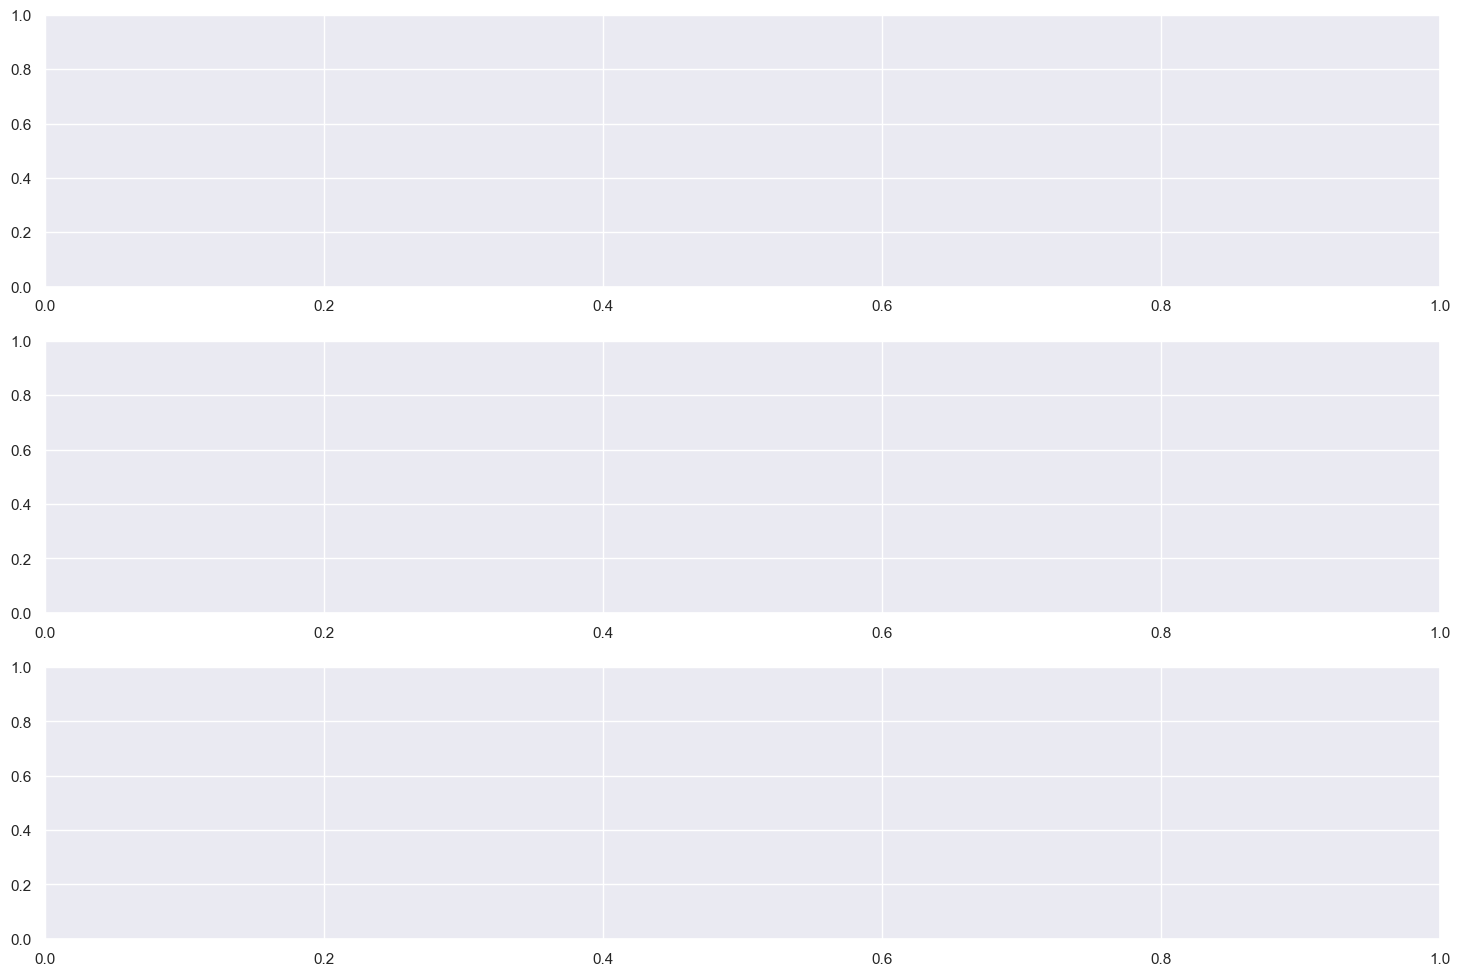

In [43]:
## Plotting the results together
M = 3
N = 1

fig, ax = plt.subplots(M, N, figsize=(18, 12))

ax[0].plot(df1['adj_close'], color='mediumblue', label='Prices', linewidth=0.8)
ax[0].set_title(f"{ticker1} stock  - Adjusted close price over time", fontsize=20)
ax[0].set_ylabel("Price (INR)", fontsize=15)

ax[1].plot(df1['simple_returns'], color='olive', label='Daily simple returns')
ax[1].set_title(f"{ticker1} stock  - Daily simple returns", fontsize=20)
ax[1].set_ylabel("Simple returns (%)", fontsize=15)

ax[2].plot(df1['log_returns'], color='forestgreen', label='Daily log returns')
ax[2].set_title(f"{ticker1} stock - Daily log returns", fontsize=20)
ax[2].set_ylabel("Log returns (%)", fontsize=15)


for i in range(3):
    for eachyear in range(start1.year,end1.year):
        ax[i].axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

ax[0].axhline(df1['adj_close'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
ax[1].axhline(0, color='maroon', label='Zero line', linestyle='--', alpha=0.7)
ax[2].axhline(0, color='maroon', label='Zero line', linestyle='--', alpha=0.7)

# Legend addition
#ax[0].legend(['Prices', 'Mean price'], loc='best')
#ax[1].legend(['Daily simple returns', 'Zero line'], loc='best')
#ax[2].legend(['Daily log returns', 'Zero line'], loc='best')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')


# To set the spacing between subplots
plt.subplots_adjust(hspace=0.4)

__Observations__
- Similarity in the shapes of the simple returns and log returns. There is a difference in scale as we see from the Y-axis.
- Compare both return values (from the `pandas DataFrame`). What do you see?
- Plotting the price and the returns side by side allows us to observe the relationship between price and volatility in returns.

### ACF and PACF

Consider a supermarket near your home which has deep discounts on staples (rice, flour, sugar, potatoes) on Tuesdays, Thursdays and Saturdays each week.
The price of staples on Monday will directly influence their prices on Wednesday, the prices on Tuesday will directly affect their prices on Thursday and so on.

We can calculate this influence using the well known idea of correlation. How?

We line up 2-day old prices in a column and the present day's prices in another column. 
We then compute the correlations of these two columns of numbers. That's it!

We call this auto-correlation or serial correlation. 'Auto' here means 'self'. Since we're computing correlation of a variable with itself (i.e. a past version of itself).

Mathematically, we can write this as $Corr(S_t, S_{t-2})$.\
This is also called the ACF at lag 2.

As we can see, calculating the autocorrelation is quite straightforward.

When we look at what affects the Wednesday prices of staples, we observe that
- Monday prices influence Wednesday prices (since those are the days when staples are sold at discounted rates)
- There's going to be another effect where Monday prices influence Tuesday prices which influence Wednesday's prices. i.e. the indirect effect of Monday's prices via Tuesday's prices are seen on Wednesday's prices.

![Image](acf_pacf_2.jpg)

The PACF helps us in capturing ONLY the direct effect of Monday's prices on Wednesday's prices.\
It does so via multiple regression where $S_t = \phi_{21}S_{t-1} + \phi_{22}S_{t-2} + \epsilon_t$\
Here $\phi_{22}$ will be the PACF at lag 2.

Fortunately, we don't need to delve into the hairy math and modeling to compute PACF or ACF at different lags. There are many statistical libraries like `statsmodels` which will do it with a single line of code.

#### In summary,
<div class="alert alert-info">

- The PACF at lag $k$, is the **direct** correlation between the value of something today and its value $k$ periods back i.e. it removes the indirect effects that occur via shorter lags $k-1, k-2, k-3,..., 1$
- The ACF at lag $k$, is the correlation **(direct + indirect)** between the value of something today and its value $k$ periods back.
</div>

## Autoregressive models

Etymologically, autoregressive = auto (self) + regressive

Regression is a method by which we try to predict something based on other things.
In autoregression, we try to predict something based on the past values of that same thing.

The something I refer to above, could be the price of some object, its weight, its quantity produced, etc.

Let's start with an autoregressive model of order 1, denoted as $AR(1)$.

$$AR(1): S_t = \phi_0 + \phi_1 S_{t-1} + \epsilon_t$$

Here,
- $S_t$: Value of the variable $S$ at time $t$
- $S_{t-1}$: Value of the variable $S$ at time $t-1$
- $\phi_0$: the intercept
- $\phi_1$: the parameter/slope we want to estimate
- $\epsilon_t$: the error/residual at time $t$

I directly use some material from the Quantra course on Financial Time Series Analysis below

### Forecasting prices using the $AR(1)$ model

We now train the AR(1) model using the ARIMA method from the `statsmodels` library.

The ARIMA method can be imported as below

```python
from statsmodels.tsa.arima.model import ARIMA
```

Using the `ARIMA` method, models can be trained as

`ARIMA(data, (p, d, q))`

where

- p is the AR parameter, that needs to be defined or worked out.
- d is the difference parameter. This will be zero in case of AR models.
- q is the MA parameter. This will also be zero in case of an AR model.


In particular, the autoregressive model can be trained as

`ARIMA(data, (p, 0, 0))`

In [44]:
## Importing the required libraries


import numpy as np
import pandas as pd

import time

import datetime
import matplotlib.pyplot as plt
#plt.style.use("seaborn-talk")
import yfinance as yf
import nasdaqdatalink


import scipy.stats as scs
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nasdaqdatalink'

In [45]:
from statsmodels.tsa.arima.model import ARIMA

In [46]:
start1 = datetime.date(2011, 12, 25)
end1 = datetime.date(2023, 6, 21)
ticker1 = "NFLX"

In [47]:
df = yf.download(ticker1, start=start1, end=end1)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker1} data")

[*********************100%***********************]  1 of 1 completed

Downloaded 2888 rows and 5 columns of NFLX data


In [48]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2011-12-27,10.085714,10.355714,10.028571,10.328571,21940800
2011-12-28,9.885714,10.142857,9.795714,10.074286,23597000
2011-12-29,9.900000,9.984286,9.658571,9.854286,26163200
2011-12-30,9.898571,10.084286,9.832857,9.872857,21809200
2012-01-03,10.320000,10.388571,10.018571,10.040000,29213800


In [14]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2023-06-13,435.730011,437.269989,428.399994,430.010010,7820500
2023-06-14,440.859985,447.329987,433.500000,434.989990,8413100
2023-06-15,445.269989,448.649994,439.500000,444.100006,7099900
2023-06-16,431.959991,447.510010,430.899994,446.149994,8745500
2023-06-20,434.700012,440.000000,430.000000,430.179993,4756000


In [15]:
df.isna().sum()

Price   Ticker
Close   NFLX      0
High    NFLX      0
Low     NFLX      0
Open    NFLX      0
Volume  NFLX      0
dtype: int64

In [16]:
df2 = df.copy()

In [17]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df2 = df2.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

KeyError: "Column(s) ['Adj Close', 'Close', 'High', 'Low', 'Open'] do not exist"

In [18]:
df2.tail()

Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2023-06-13,435.730011,437.269989,428.399994,430.010010,7820500
2023-06-14,440.859985,447.329987,433.500000,434.989990,8413100
2023-06-15,445.269989,448.649994,439.500000,444.100006,7099900
2023-06-16,431.959991,447.510010,430.899994,446.149994,8745500
2023-06-20,434.700012,440.000000,430.000000,430.179993,4756000


In [19]:
df2.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df2.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)

In [20]:
df2.tail()

Price,Volume
Ticker,NFLX
Date,
2023-06-13,7820500
2023-06-14,8413100
2023-06-15,7099900
2023-06-16,8745500
2023-06-20,4756000


In [21]:
df2.shape

(2888, 1)

In [22]:
# Plot the series
plt.figure(figsize=(12, 8))
plt.plot(df2['adj_close'], color='blue')
plt.title(f"{ticker1} prices over time", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Price in US$", fontsize=16)
plt.tight_layout()


for eachyear in range(start1.year, end1.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

plt.axhline(df2['adj_close'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

KeyError: 'adj_close'

<Figure size 1200x800 with 0 Axes>

In [49]:
sm.graphics.tsa.plot_acf(df2['adj_close'], lags=50, alpha=0.05);

NameError: name 'sm' is not defined

In [50]:
sm.graphics.tsa.plot_pacf(df2['adj_close'], lags=50, alpha=0.05);

NameError: name 'sm' is not defined

Based on PACF, and to keep things simple, let's start with an AR(1)

In [51]:
df2.tail()

Price,Volume
Ticker,NFLX
Date,
2023-06-13,7820500
2023-06-14,8413100
2023-06-15,7099900
2023-06-16,8745500
2023-06-20,4756000


In [52]:
## Set the train and test data

train_end = datetime.date(2022, 4, 30)
test_end = end1

df2_train = df2[:train_end]
df2_test = df2[train_end + pd.Timedelta(days=1): test_end]

In [53]:
df2.shape, df2_train.shape, df2_test.shape

((2888, 1), (2603, 1), (285, 1))

In [54]:
## Instantiate/define the model

model2a = ARIMA(df2_train['adj_close'], order=(1, 0, 0))

KeyError: 'adj_close'

In [55]:
## Fit the model
starting = time.time()
model2a_fit = model2a.fit()
ending = time.time()
print(f"Time taken to fit the model:{round(ending-starting, 2)} seconds")

NameError: name 'model2a' is not defined

In [24]:
# Model summary

print(model2a_fit.summary())

NameError: name 'model2a_fit' is not defined

### Predicted model:

From the output above, we see that

$\phi_0 = 216.52$, and $\phi_1 = 0.99$

So the model works out to \
$\hat{S_t} = 216.52 + 0.99 S_{t-1}$

In [25]:
predict_start = df2_test.index[0]
predict_end = df2_test.index[-1]

NameError: name 'df2_test' is not defined

In [26]:
predict_start, predict_end

NameError: name 'predict_start' is not defined

In [27]:
# Predict the output in the test set
starting = time.time()
predicted_values = model2a_fit.predict(start= predict_start, end = predict_end)
residual_values = df2_test['adj_close'] - predicted_values
ending = time.time()

print(f"Time taken to forecast out-of-sample: {round(ending-starting, 2)} seconds")


NameError: name 'model2a_fit' is not defined

In [28]:
# Plot the residuals

plt.figure(figsize=(12, 8))
plt.plot(residual_values)
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Errors", fontsize=16)
plt.tight_layout()

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)


plt.axhline(0, label='Zero error', color = 'purple', linestyle='--', alpha=0.7)
plt.axhline(residual_values.mean(), label='Mean error', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

NameError: name 'residual_values' is not defined

<Figure size 1200x800 with 0 Axes>

In [29]:
# Plot the predicted v/s the actual values

plt.figure(figsize=(12, 8))
plt.plot(df2_test['adj_close'])
plt.plot(predicted_values)
plt.title(f"Predicted v/s actuals from the AR(1) model", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Prices", fontsize=16)

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)
    
plt.legend(('Actual', 'Predicted'), fontsize=16 )
plt.tight_layout()


NameError: name 'df2_test' is not defined

<Figure size 1200x800 with 0 Axes>

In [56]:
print("Mean absolute percent error:", 100 * round(np.mean(abs(residual_values/df2_test['adj_close'])), 3))
print("Root mean squared error:", round(np.sqrt(np.mean(residual_values**2)), 2))

NameError: name 'residual_values' is not defined

Considering the plots, and the errors we've encountered, the above approach is not a good way to go about it.


### What's the alternative then?

#### Answer: Rolling forecasts

Many machine learning models are not time-indexed. Conventionally, the train-test split (80:20, 90:10, etc.) approach is good to build and forecast ML models. But with time series, if we try to forecast the final 20% based on the initial 80%, we'll probably do alright for the first few predictions. 

However, as we make further forecasts, we rely on previous forecasts to make the next one. So the further we predict, the worse they tend to be.

In order to take advantage of the temporal structure of our data, we can instead predict one or two time periods ahead. We then update our models after each time period to forecast the next one or two time periods. That is, we create rolling forecasts, which, although computationally intensive, are better than the earlier approach.

In [57]:
## Instantiate/define the model

model2b = ARIMA(df2_train['adj_close'], order=(1, 0, 0))

## Fit the model
starting = time.time()
model2b_fit = model2b.fit()
ending = time.time()
print(f"Time taken to fit the model: {round(ending-starting, 2)} seconds")

KeyError: 'adj_close'

In [58]:
# Function to predict the price of 1 period ahead
def predict_price_AR(train_data):
    # Define the model
    model = ARIMA(train_data, order=(1, 0, 0))

    # Fit the model
    model_fit = model.fit()

    # Make the forecast
    forecast_results = model_fit.forecast()

    return forecast_results[0]

In [59]:
rolling_window = df2_train.shape[0]

In [60]:
starting = time.time()

# Predict the price using `predict_price_AR` function
df2['predicted_price'] = df2['adj_close'].rolling(rolling_window).apply(predict_price_AR)
# Shift the predicted price by 1 period
df2['predicted_price'] = df2['predicted_price'].shift(1)
df2['error'] = df2['adj_close'] - df2['predicted_price']
ending = time.time()
print(f"Time taken for the rolling forecasts: {round(ending-starting, 2)} seconds")

KeyError: 'adj_close'

In [61]:
# Plot the residuals

plt.figure(figsize=(12, 8))
plt.plot(df2['error'])
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Errors", fontsize=16)
plt.tight_layout()

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)


plt.axhline(0, label='Zero error', color = 'purple', linestyle='--', alpha=0.7)
plt.axhline(df2['error'].mean(), label='Mean error', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

KeyError: 'error'

<Figure size 1200x800 with 0 Axes>

In [62]:
# Plot the predicted v/s the actual values

plt.figure(figsize=(12, 8))
plt.plot(df2_test['adj_close'])
plt.plot(df2['predicted_price'])
plt.title(f"Predicted v/s actuals from the AR(1) model", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Prices", fontsize=16)

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)
    
plt.legend(('Actual', 'Predicted'), fontsize=16 )
plt.tight_layout()

KeyError: 'adj_close'

<Figure size 1200x800 with 0 Axes>

In [63]:
print("Mean absolute percent error:", 100*round(np.mean(abs(df2['error']/df2.loc[predict_start:, 'adj_close'])), 3))
print("Root mean squared error:", round(np.sqrt(np.mean(df2['error']**2)), 3))

KeyError: 'error'

In [64]:
import matplotlib.dates as mdates

# For statistical analysis
#from statsmodels.graphics.tsaplots import plot_pacf
#from statsmodels.graphics.tsaplots import plot_acf

In [77]:
# Import libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def model_performance(observed, predicted):

    
    """This function will print the Mean Absolute Error, Mean Squared Error,
    Root Mean Squared Error and Mean Absolute Percentage Error.
    This function will also display the residula plot and the ACF.
    """

    # Mean Absolute Error
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)

    # Mean Squared Error
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)

    # Mean Absolute Percentage Error
    mape = 100 * ((observed-predicted)/observed).abs().mean()
    print('The Mean Absolute Percentage Error is %.2f' % mape)

    # Residuals
    residuals = observed - predicted
    labels = observed.index
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11))
    
    # Plot residual
    observed.plot(ax=ax1, color='purple')
    predicted.plot(ax=ax1, color='green')
    ax1.set_ylabel('Price')
    ax1.set_title('Predicted Vs. Observed')
    
    # Plot residual
    ax2.fill_between(residuals.index, residuals.values, color='red')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Date')
    ax2.set_title('Residual')
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    _=plt.xticks(rotation=45)
    
    # Autocorrelation plot of residuals
    sm.graphics.tsa.plot_pacf(residuals, ax=ax3, color='blue')
    ax3.set_xlabel('Lags')
    ax3.set_ylabel('Partial Autocorrelation')
    ax3.set_title('Partial Autocorrelation of Residuals')

    plt.tight_layout()
    plt.show()

# Call `model_performance` to evaluate the performance of the model
model_performance(df2['adj_close'].iloc[rolling_window:],
                  df2['predicted_price'].iloc[rolling_window:])

KeyError: 'adj_close'

__Observations__

- From the first plot above, you can see that the predicted values are close to the observed value.

- From the second plot above, you can see that the residuals are random. The magnitude of the errors varies through time. The model appears more error-prone in the first couple of months and then the magnitude of errors is smaller until November 2022.

- From the third plot above, you can see that there is little autocorrelation between the residuals. There are a few minor spikes at lags 4, 9 and 10.

### Finding the optimal order for AR models

We rely on the PACF plot to give us an idea of the order for AR models and the ACF plot for the order of MA models.

Let's now inspect the PACF plot more closely to consider a different order for the AR model.

In [ ]:
### Finding the optimal order for AR

fig, ax = plt.subplots(figsize=(12, 7))
sm.graphics.tsa.plot_pacf(df2['adj_close'], lags=30, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

There are spikes at lags 1, 4, 7, 8, 15, 24, and 28. The higher order we pick, the higher the chance of overfitting. So we'll avoid picking the highest value and choose 8 as the order of our AR model.

### Train the AR(8) model using the `ARIMA` method from `statsmodels`

In [78]:
df2 = df.copy()

In [79]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df2 = df2.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

KeyError: "Column(s) ['Adj Close', 'Close', 'High', 'Low', 'Open'] do not exist"

In [80]:
df2.tail()

Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2023-06-13,435.730011,437.269989,428.399994,430.010010,7820500
2023-06-14,440.859985,447.329987,433.500000,434.989990,8413100
2023-06-15,445.269989,448.649994,439.500000,444.100006,7099900
2023-06-16,431.959991,447.510010,430.899994,446.149994,8745500
2023-06-20,434.700012,440.000000,430.000000,430.179993,4756000


In [81]:
df2.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df2.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)

In [82]:
## Set the train and test data

train_end = datetime.date(2022, 4, 30)
test_end = end1

df2_train = df2[:train_end]
df2_test = df2[train_end + pd.Timedelta(days=1): test_end]

In [83]:
df2.shape, df2_train.shape, df2_test.shape

((2888, 1), (2603, 1), (285, 1))

In [84]:
## Instantiate/define the model of order 8

model2c = ARIMA(df2_train['adj_close'], order=(8, 0, 0))

## Fit the model
starting = time.time()
model2c_fit = model2c.fit()
ending = time.time()
print(f"Time taken to fit the model: {round(ending-starting, 2)} seconds")

KeyError: 'adj_close'

In [85]:
# Model summary

print(model2c_fit.summary())

NameError: name 'model2c_fit' is not defined

We have an autoregressive model of order 8, denoted as $AR(8)$.

$$AR(8): S_t = \phi_0 + \phi_1 S_{t-1} + \phi_2 S_{t-2} + ... + \phi_8 S_{t-8} + \epsilon_t$$

Here,
- $S_t$: Value of the variable $S$ at time $t$
- $S_{t-i} (i=1, 2, ..., 8) $: Value of the variable $S$ at time $t-i$
- $\phi_0$: the intercept
- $\phi_i (i=1, 2, ..., 8)$: the parameters/slopes we want to estimate
- $\epsilon_t$: the error/residual at time $t$

From the output above, the fitted model is
$$ AR(8) : \hat{S_t} = 216.54 + 0.96*S_{t-1} + ~...~ - 0.17*S_{t-8}$$



In [86]:
# Function to predict the price of 1 day
def predict_price_AR(train_data):
    # Define model
    model = ARIMA(train_data,order=(8, 0, 0))
    
    # Fit the model
    model_fit = model.fit()  
    
    # Make forecast
    forecast_results = model_fit.forecast()  
    
    return forecast_results[0]

_Note: The below cell will take a while to run. Please be patient._

In [87]:
starting = time.time()
# Predict the price using 'predict_price_AR' function
df2['predicted_price'] = df2['adj_close'].rolling(rolling_window).apply(predict_price_AR)
# Shift the predicted price by 1 period
df2['predicted_price'] = df2['predicted_price'].shift(1)
ending = time.time()
print(f"Time taken for the rolling forecasts: {round(ending-starting, 2)} seconds")

KeyError: 'adj_close'

In [88]:
df2.round(2).tail()

Price,Volume
Ticker,NFLX
Date,
2023-06-13,7820500
2023-06-14,8413100
2023-06-15,7099900
2023-06-16,8745500
2023-06-20,4756000


In [89]:
# Call `model_performance` to evaluate the performance of the model
model_performance(df2['adj_close'].iloc[rolling_window:], df2['predicted_price'].iloc[rolling_window:])

KeyError: 'adj_close'

### Creating a trading strategy using the AR model

Let us create a trading strategy using the predictions made above. We go long on the asset if the predicted price at time $~t~$ is greater than the predicted price at the previous time $~t-1$ and go short if it's vice-versa.


In [91]:
df2['cc_returns'] = df2['adj_close'].pct_change()
# Create signal
df2['signal'] = np.where(df2['predicted_price'].shift(1) < df2['predicted_price'], 1, -1)
df2['strategy_returns'] = df2['signal'].shift(1) * df2['cc_returns']
df2.tail().round(2)

KeyError: 'adj_close'

In [92]:
def analyze_strategy(strategy_returns):    
    
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

    # Cumulative Returns
    cumulative_returns = (strategy_returns + 1).cumprod()
    
    # ---------- Drawdown calculations -------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = 100*((cumulative_returns)/running_max - 1)

    # Calculate the maximum drawdown
    max_dd = drawdown.min()

    # Print the statistics
    print('The Sharpe Ratio is %.2f' % sharpe_ratio)
    print('The cumulative return is %.2f' % (
      ((cumulative_returns[-1])-1)*100) + "%") 
    print("The maximum drawdown is %.2f" % max_dd + "%")

    # Plot
    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    # Plot strategy returns
    ax1.plot(cumulative_returns, color='b')
    ax1.set_title('Cumulative Returns', fontsize=14)
    ax1.set_ylabel('Cumulative Returns', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
   
    # Plot max DD
    ax2.plot(drawdown, color='red')
    # Fill in-between the drawdown
    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))

    plt.tight_layout()
    plt.show()

In [93]:
# Call analyze_strategy
analyze_strategy(df2['strategy_returns'].iloc[rolling_window:])    

KeyError: 'strategy_returns'

## Moving average models

In a moving average model, the observed variable is a linear function of the current and past values of the error terms. A moving average model of order q, $MA(q)$ 

$$ MA(q) : X_t = \mu + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q} + \epsilon_{t}  $$

where 
* $\mu$ : mean of the observed variable
* $\theta_i (i=1, 2, ..., q) $ : parameters of the model
* $\epsilon_t$ : error term
* $X_t$ : observation at time t

The values of $\mu$, $\theta_1$, ..., $\theta_q$ cannot be estimated by using the standard regression formula as the equation involves the unknown error term. They are found by iteration.


## Train MA(q) model using `ARIMA` method from the `statsmodels` library

Let us train the MA(q) model using the `ARIMA` method from the `statsmodels` library.

Using the `ARIMA` method, the moving average model can be trained as
```python
ARIMA(data, (p, d, q))
```

where 
* p is the AR parameter, this will be zero in case of a MA model.
* d is the difference, this will be set to 1 if the series is non-stationary.
* q is the MA parameter, that needs to be defined or optimized

Hence, the moving average model can be trained as
```python
ARIMA(data, (0, 1, q))
```


In [65]:
# Read the csv file using read_csv method of pandas
data = pd.read_csv("ASQ_01_data_wheat_etf_price_2011_2020.csv", index_col=0)
data.index = pd.to_datetime(data.index)

# Drop the missing values
data = data.dropna()

# Rolling Window
rolling_window = int(len(data)*0.70)

### Optimizing the order of the MA(q) model

We rely on the PACF plot to give us an idea of the order for AR models and the ACF plot for the order of MA models.

Let's now inspect the ACF plot more closely to consider the order for the MA model.


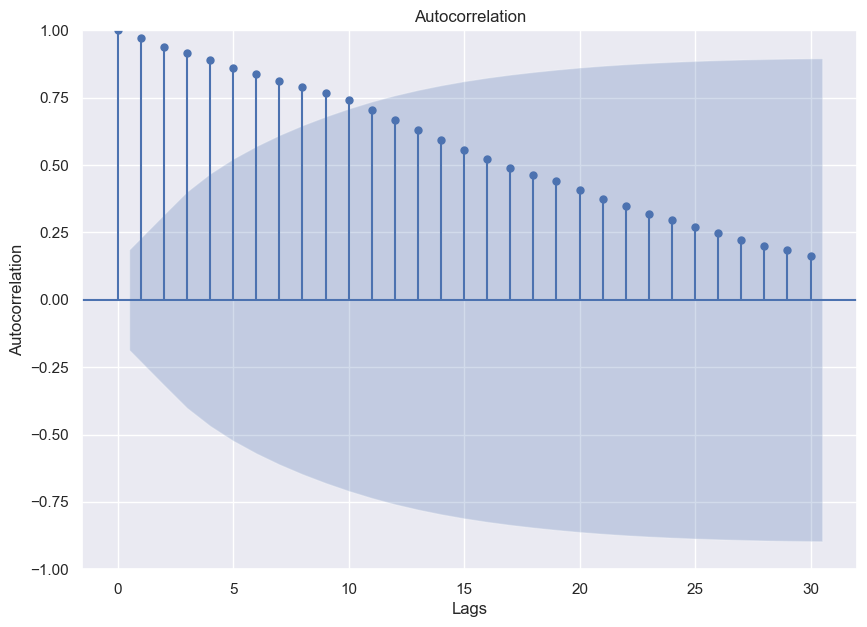

In [66]:
fig, ax = plt.subplots(figsize=(10, 7))
sm.graphics.tsa.plot_acf(data['Adj Close'], lags=30, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Based on the above plot, the spikes are signficant until lag 10. So we can work with an MA(10) model.

In [67]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima.model.ARIMA', FutureWarning)

In [68]:
# Train the moving average model of order 10
model_fit_0 = ARIMA(data['Adj Close'][:rolling_window], order=(0, 1, 10)).fit()
print(model_fit_0.params.round(2))

ma.L1     0.22
ma.L2    -0.17
ma.L3    -0.08
ma.L4     0.04
ma.L5    -0.22
ma.L6     0.11
ma.L7     0.11
ma.L8     0.09
ma.L9    -0.26
ma.L10    0.34
sigma2    0.75
dtype: float64


From the output above, you can see that the fitted model is
$$ MA(10): \hat{y_t} =  \epsilon_t + 0.22*\epsilon_{t-1} - ~...~ + 0.34*y_{t-10}$$

In [69]:
print(model_fit_0.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   77
Model:                ARIMA(0, 1, 10)   Log Likelihood                 -99.366
Date:                Thu, 18 Jul 2024   AIC                            220.731
Time:                        12:22:47   BIC                            246.369
Sample:                    09-01-2011   HQIC                           230.978
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2154      0.398      0.542      0.588      -0.564       0.995
ma.L2         -0.1690      0.233     -0.727      0.467      -0.625       0.287
ma.L3         -0.0796      0.151     -0.527      0.5

In [94]:
# Function to predict the price of 1 day
def predict_price_MA(train_data):
    # Define model
    model = ARIMA(train_data, order=(0, 1, 10))
    # Fit the model
    model_fit = model.fit()
    # Make forecast
    forecast_results = model_fit.forecast()
    return forecast_results[0]

In [95]:
%%timeit

# Predict the price using `predict_price_MA` function
data['predicted_price'] = data['Adj Close'].rolling(rolling_window).apply(predict_price_MA)
# Shift the predicted price by 1 period
data['predicted_price'] = data['predicted_price'].shift(1)

NameError: name 'data' is not defined

The Mean Absolute Error is 0.36
The Mean Squared Error is 0.22
The Root Mean Squared Error is 0.46
The Mean Absolute Percentage Error is 6.16


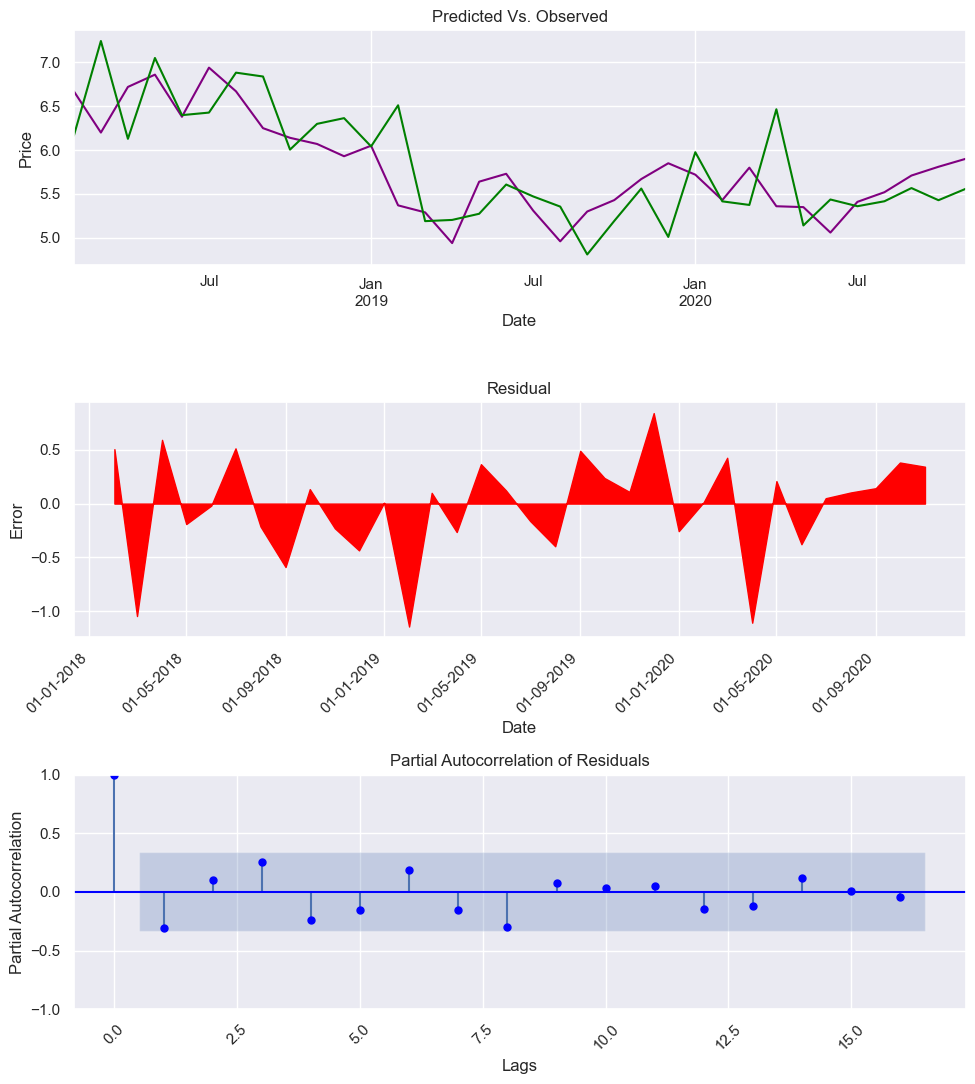

In [72]:
# Call `model_performance` to evaluate the performance of the model
model_performance(data['Adj Close'].iloc[rolling_window:], data['predicted_price'].iloc[rolling_window:])

The residuals here are more positive than negative. Hence the model has under predicted in more cases. From the third plot, you can see that there is autocorrelation between the residuals at lags 3, 8, and 14.

## Creating a trading strategy using the MA(10) model


In [96]:
data['wheat_returns'] = data['Adj Close'].pct_change()
# Create signal
data['signal'] = np.where(data.predicted_price.shift(1) < data.predicted_price, 1, -1)
data['strategy_returns'] = data.signal.shift(1) * data.wheat_returns

NameError: name 'data' is not defined

In [97]:
# Call `analyze_strategy`
analyze_strategy((data['strategy_returns']).iloc[rolling_window:])

NameError: name 'data' is not defined

### Stylized facts of asset returns

[Cont (2001)](#cont2001) does a detailed review of the empirical features of asset prices in financial markets. He presents common statistical properties (***stylized facts***) that financial asset returns share across markets, instruments and time periods.

We should be cognizant of them when we develop models to explain and forecast asset prices. 
We now work with 40 years of S&P daily data to examine some of their characteristics.

In [75]:
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [76]:
end2 = datetime.date(2023, 6, 21)
start2 = datetime.date(1980, 1, 2)
ticker2 = "^GSPC"

In [77]:
df = yf.download(ticker2, start=start2, end=end2, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker2} data")

Downloaded 10959 rows and 6 columns of ^GSPC data


In [78]:
df2 = df.copy()

In [79]:
#############################################################################
###################### IGNORE THIS CELL #####################################
#############################################################################

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df2.to_csv("GLENMARK.NS.csv")
# df2 = pd.read_csv("GLENMARK.NS", index_col=0, parse_dates=True)
# df2 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [80]:
print(df2.head())
print(df2.tail())

            Open        High         Low       Close   Adj Close    Volume
Date                                                                      
1980-01-02   0.0  108.430000  105.290001  105.760002  105.760002  40610000
1980-01-03   0.0  106.080002  103.260002  105.220001  105.220001  50480000
1980-01-04   0.0  107.080002  105.089996  106.519997  106.519997  39130000
1980-01-07   0.0  107.800003  105.800003  106.809998  106.809998  44500000
1980-01-08   0.0  109.290001  106.290001  108.949997  108.949997  53390000
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-06-13  4352.609863  4375.370117  4349.310059  4369.009766  4369.009766   
2023-06-14  4366.290039  4391.819824  4337.850098  4372.589844  4372.589844   
2023-06-15  4365.330078  4439.200195  4362.600098  4425.839844  4425.839844   
2023-06-16  4440.950195  4448.470215  4407.439941  4409.589844  4409.589844   
2

In [81]:
df2.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df2.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df2.tail())

              adj_close
Date                   
2023-06-13  4369.009766
2023-06-14  4372.589844
2023-06-15  4425.839844
2023-06-16  4409.589844
2023-06-20  4388.709961


In [82]:
df2['log_returns'] = np.log(df2['adj_close'] / df2['adj_close'].shift(1))

#### 1. Non-normal distribution of returns

A standard assumption in finance models (like the CAPM, the Black-Scholes option pricing model) is that returns are normally distributed.

Numerous studies have however shown empirically that this is not quite true.
Specifically,
- *Left skewed* : Gains and loss distributions are not symmetrical. 
    - We see longer left tails compared to the right tails
    - The large negative returns are higher in magnitude compared to the large positive returns. 
 
- *Excess kurtosis* : The distribution is fat at the tails and higher than normal peaks
    - Large (and small) returns occur more frequently than the distributional assumption of normality expects.



In [83]:
df2.head()

,adj_close,log_returns
Date,,
1980-01-02,105.760002,NaN
1980-01-03,105.220001,-0.005119
1980-01-04,106.519997,0.012279
1980-01-07,106.809998,0.002719
1980-01-08,108.949997,0.019838


In [84]:
df2.dropna(axis='rows', how='any', inplace=True)

In [85]:
## Generating a normal distribution curve with mean, variance, and range obtained from S&P 500 returns data

log_returns_range = np.linspace(min(df2['log_returns']), max(df2['log_returns']), num=1000)
μ = df2['log_returns'].mean()
σ = df2['log_returns'].std()
norm_pdf = scs.norm.pdf(log_returns_range, loc=μ, scale=σ)

Text(0.5, 1.0, 'Q-Q plot')

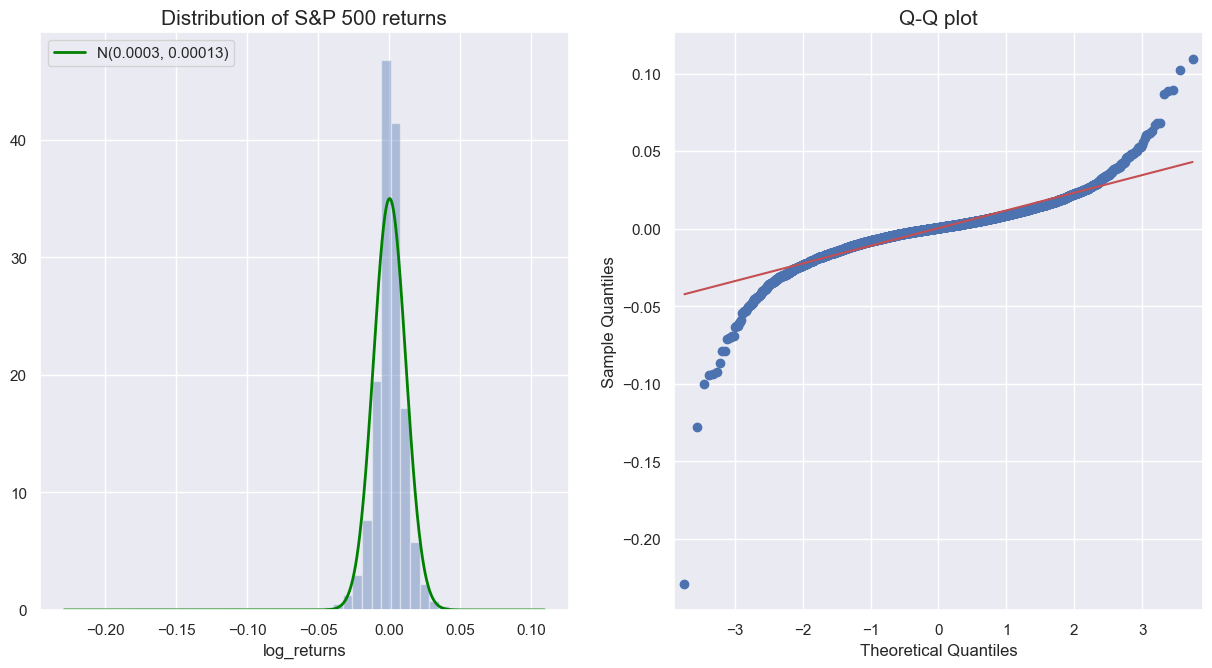

In [86]:
M = 1
N = 2

fig, ax = plt.subplots(M, N, figsize=(15, 7.5))

## histogram

sns.distplot(df2['log_returns'], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of S&P 500 returns", fontsize=15)
ax[0].plot(log_returns_range, norm_pdf, color='green', 
           linewidth=2, label=f"N({μ:.4f}, {σ**2:.5f})")
ax[0].legend(loc="best")

## Q-Q plot

qq_plot = sm.qqplot(df2['log_returns'], line='s', ax=ax[1])
## 's' is for standardized line to compare the plot with a normal distribution
ax[1].set_title("Q-Q plot", fontsize=15)

Points to note: *Distribution of S&P 500 returns*
- There is a visible difference in the shape of the returns histogram and the Gaussian (normal) distribution curve.
- The peak is higher in the histogram than the normal curve.
- The left tail of the distribution is longer.

Points to note: *Q-Q plot*

- Q-Q plots are used to compare empirical data to theoretical distributions. They are helpful in finding deviations at the tails.
- Here, we compare the distribution of the observed returns to a normal distribution.
- If we find that the dots are more or less on the red line, then it means that the data (in this case returns) is normally distributed.
- There is drift at both ends of the tails. This means that we have fatter tails violating the normality assumption.
- The size of the drift is higher on the left side of the plot than on the right side. This means that we observe large drops in returns but not equally large growths in returns.


In [87]:
## Running the Jarque-Bera test to check for normality of the sample data
## If the test statistic is very large and the p-value is less than 5%, we infer that the data is not
## normally distributed.

## For more details, check https://en.wikipedia.org/wiki/Jarque-Bera_test

from statsmodels.stats.stattools import jarque_bera
jb_test_stat, pvalue, _, _ = jarque_bera(df2['log_returns'])

In [88]:
jarque_bera?

In [89]:
## Printing the summmary statistics of the S&P 500 returns data

print('------------------- Summary Statistics --------------------')
print(f'Range of dates: {min(df2.index.date)} to {max(df2.index.date)}')
print(f'Number of observations: {df2.shape[0]}')
print(f"Mean: {df2['log_returns'].mean():.4f}")
print(f"Median: {df2['log_returns'].median():.4f}")
print(f"Min: {df2['log_returns'].min():.4f}")
print(f"Max: {df2['log_returns'].max():.4f}")
print(f"Standard Deviation: {df2['log_returns'].std():.4f}")
print(f"Skewness: {df2['log_returns'].skew():.4f}")
print(f"Kurtosis: {df2['log_returns'].kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")
print('-----------------------------------------------------------')

------------------- Summary Statistics --------------------
Range of dates: 1980-01-03 to 2023-06-20
Number of observations: 10958
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0114
Skewness: -1.0942
Kurtosis: 24.3396
Jarque-Bera statistic: 272414.62 with p-value: 0.00
-----------------------------------------------------------


Points to note:
- The mean is less than the median. Seen in negatively skewed distributions.
- Confirmed by the coefficient of skewness (which is negative).
- Excess kurtosis seen (anything above 0 is deemed as excess kurtosis. Normal distribution has a kurtosis of 0 when measured using the `pandas kurtosis` method) .
- The p-value of the Jarque-Bera test shows non-normality of the data.

#### 2. Volatility Clustering

> *When it rains, it pours*.

We observe from historical data that the volatility of the returns appears to change over time. Relatively tranquil periods in the market persist for a while. Similarly market turbulence like in 2008 and 2009 also cluster together.

In [90]:
# Simulating normally distributed returns for GLENMARK and S&P 500
sample1 = pd.DataFrame(np.random.normal(loc=df1['log_returns'].mean(), 
                                     scale=df1['log_returns'].std(), 
                                     size=df1['log_returns'].shape[0]), 
                    index = df1.index)

sample2 = pd.Series(np.random.normal(loc=df2['log_returns'].mean(), 
                                     scale=df2['log_returns'].std(), 
                                     size=df2['log_returns'].shape[0]), 
                    index = df2.index)


In [91]:
sample1.shape

(4433, 1)

In [92]:
sample2.shape

(10958,)

In [93]:
sample1.loc['July 2005', :]

,0
Date,
2005-07-01,0.000391
2005-07-04,0.039700
2005-07-05,-0.090064
2005-07-06,-0.016569
2005-07-07,-0.008632
2005-07-08,-0.021375
2005-07-11,0.104335
2005-07-12,-0.026974
2005-07-13,0.044284


Text(0.5, 1.0, 'Simulated returns')

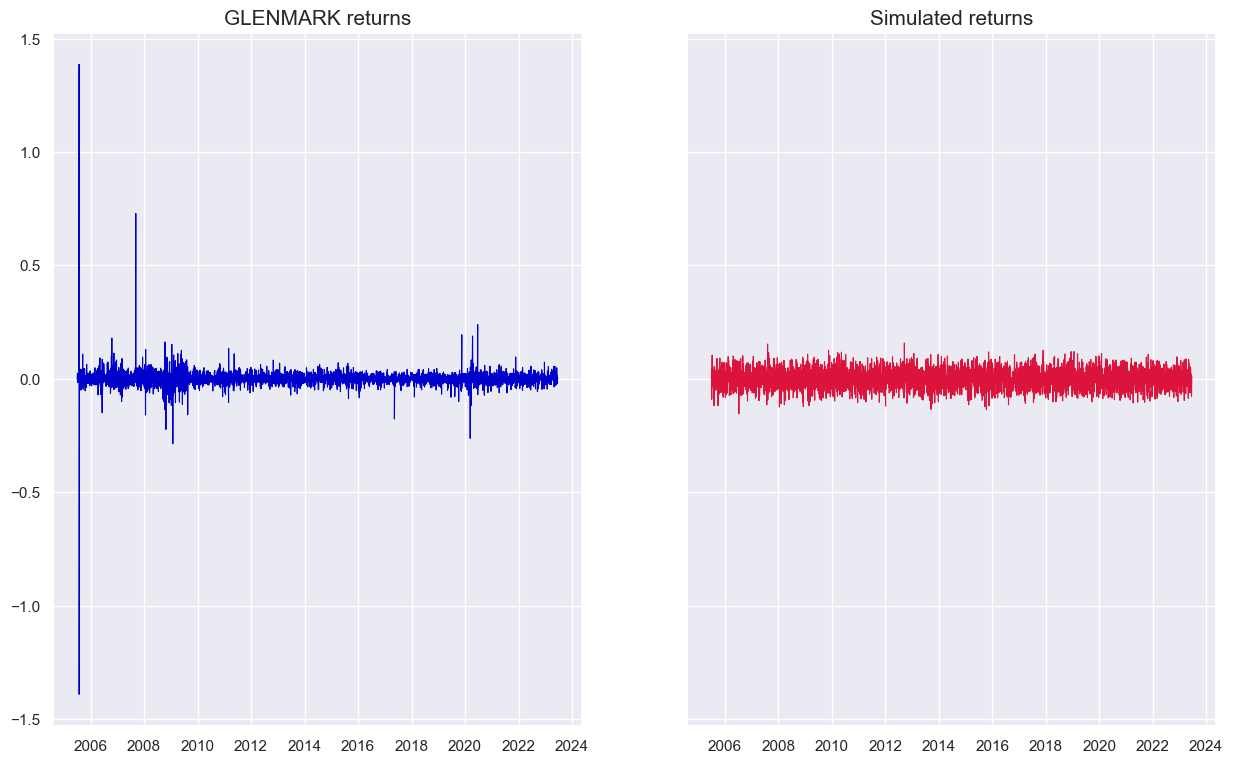

In [94]:
## Plotting the daily returns of GLENMARK and simulated data with same mean/sd side by side 

x = df1.index
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), sharey=True)
ax1.plot(x, df1['log_returns'], linewidth=0.8, color='mediumblue')
ax1.set_title("GLENMARK returns", fontsize=15)
ax2.plot(sample1, linewidth=0.8, color='crimson')
ax2.set_title("Simulated returns", fontsize=15)

Text(0.5, 1.0, 'Simulated returns')

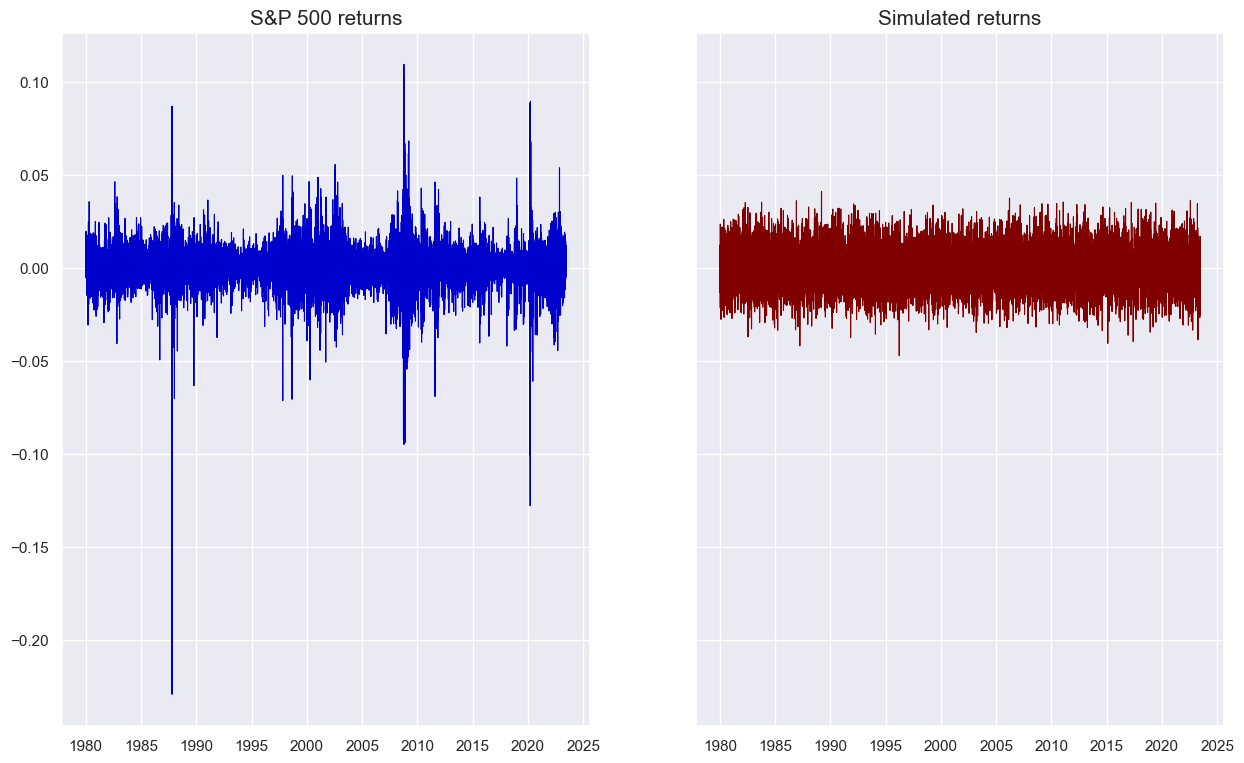

In [95]:
## Plotting the daily returns of S&P 500 and simulated data with same mean/sd side by side 

x = df2.index
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), sharey=True)
ax1.plot(x, df2['log_returns'], linewidth=0.8, color='mediumblue')
ax1.set_title("S&P 500 returns", fontsize=15)
ax2.plot(x, sample2, linewidth=0.8, color='maroon')
ax2.set_title("Simulated returns", fontsize=15)

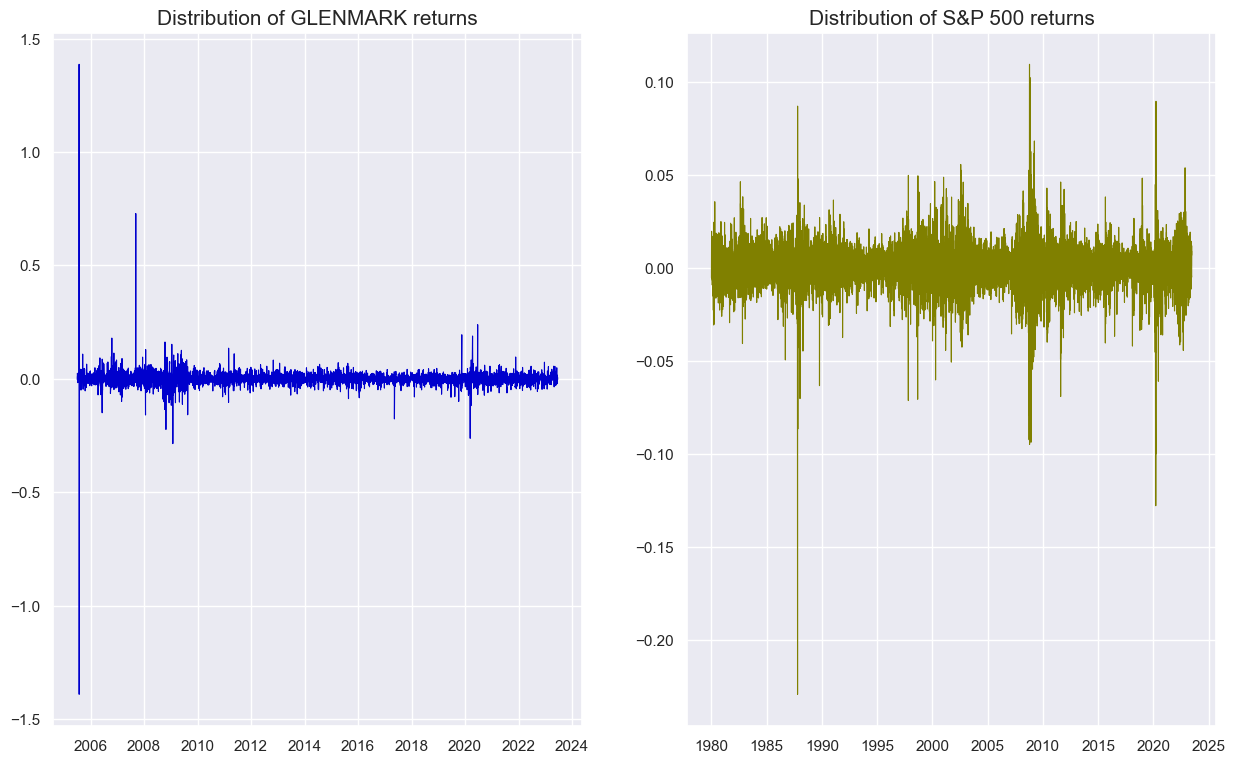

In [96]:
## Plotting the daily returns of GLENMARK and S&P 500 side by side 

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

ax[0].set_title("Distribution of GLENMARK returns", fontsize=15)
ax[0].plot(df1['log_returns'], linewidth=0.8, color='mediumblue')

ax[1].set_title("Distribution of S&P 500 returns", fontsize=15)
ax[1].plot(df2['log_returns'], linewidth=0.8, color='olive')

Points to note:
- For Glenmark, between 2008 and 2010, there's a higher swing of positive and negative returns. Notice how it's quite different from between 2016 and 2018.
- Similar waves of high and low volatility periods seen in S&P returns

#### 3. Absence of autocorrelations

Autocorrelation measures the degree of similarity between a time series process and a delayed copy of itself. We measure it at different lags to unearth any patterns that repeat consistently.

Studies have shown that there is little autocorrelation observed in asset returns except for short time scales (of the order of 15 to 20 minutes).


In [97]:
n_lags = 50
significance_level = 0.05

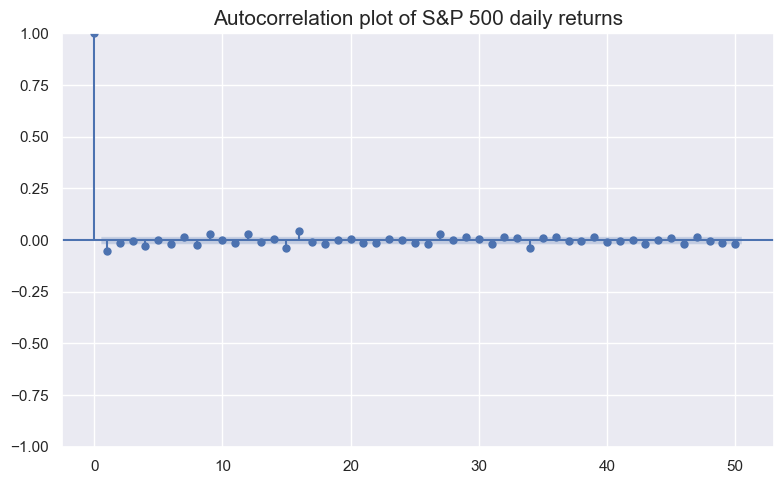

In [98]:
M = 8
N = 5

fig, ax = plt.subplots(figsize=(M, N))
smt.graphics.plot_acf(df2['log_returns'], lags=n_lags, 
                                 alpha=significance_level, ax=ax)
ax.set_title("Autocorrelation plot of S&P 500 daily returns", fontsize=15)
plt.tight_layout()
plt.show()

Points to note:
- We do not look at autocorrelation at lag 0.
- A few values that lie outside the blue confidence interval are statistically significant
- Visually, it appears that there is very little autocorrelation in the returns


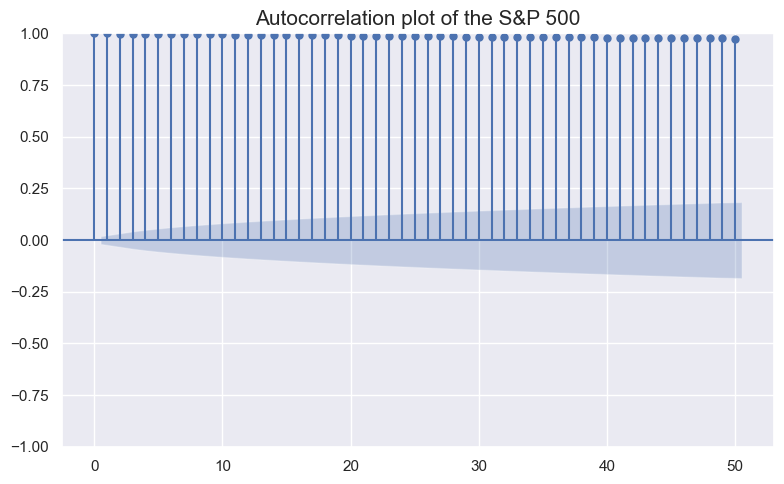

In [99]:
M = 8
N = 5

fig, ax = plt.subplots(figsize=(M, N))
smt.graphics.plot_acf(df2['adj_close'], lags=n_lags, 
                                 alpha=significance_level, ax=ax)
ax.set_title("Autocorrelation plot of the S&P 500", fontsize=15)
plt.tight_layout()
plt.show()

#### 4. Slow decay of autocorrelations in absolute and squared returns

We follow the same procedure as above but this time we run it on absolute returns and squared returns. We can then plot the autocorrelation function (ACF) at different lags.

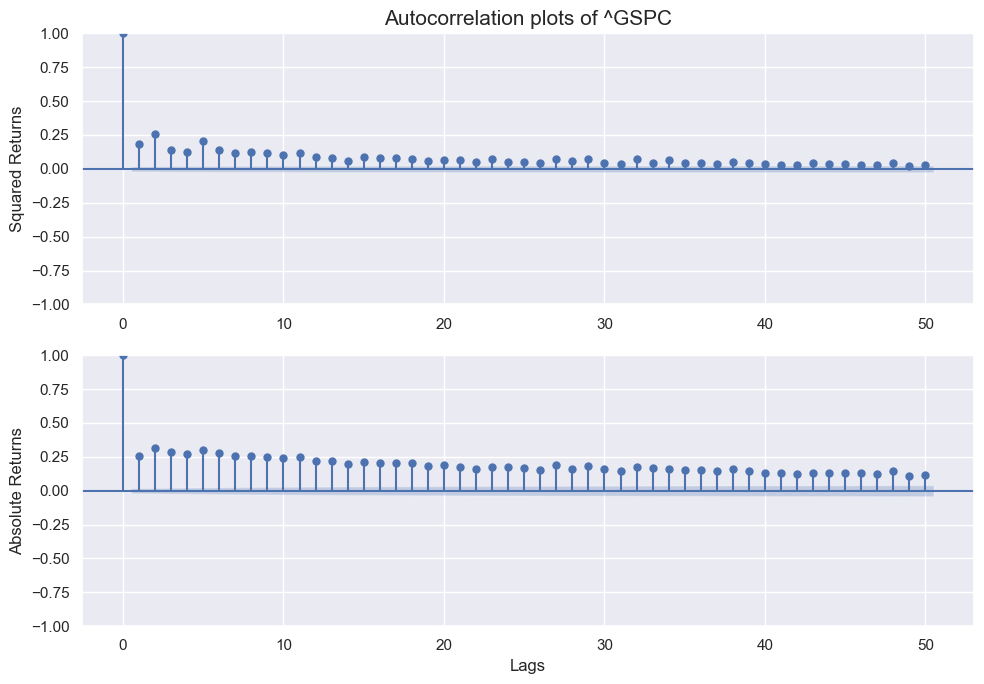

In [100]:
M, N = 10, 7
fig, ax = plt.subplots(2, 1, figsize=(M, N))
smt.graphics.plot_acf(df2['log_returns'] ** 2, lags=n_lags, 
                      alpha=significance_level, ax=ax[0])
ax[0].set_title(f"Autocorrelation plots of {ticker2}", fontsize=15)
ax[0].set(ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df2['log_returns']), lags=n_lags, 
                      alpha=significance_level, ax=ax[1])
ax[1].set(title="", xlabel='Lags', ylabel="Absolute Returns")

plt.tight_layout()
plt.show()

Points to note:
- There is is a slow and uneven decay of the ACF plot.
- The ACF of the squared returns decrease faster than that of the absolute returns.
- There is significant autocorrelation as seen in the literature.

#### 5. Leverage effect

There is a negative correlation between the volatility (most measures) of an asset and its returns. i.e. When prices go up, there is less volatility in the asset returns and vice-versa.

We verify it using two different methods. 

- In the first one, we measure volatility as the standard deviation of the asset returns. 
- In the second one, we will use the VIX index (often called the *fear index* of Wall Street), a popular market metric that tracks expectations of volatility.


In [101]:
df1['ma_std_252'] = df1['log_returns'].rolling(window=252).std()
df1['ma_std_21'] = df1['log_returns'].rolling(window=21).std()

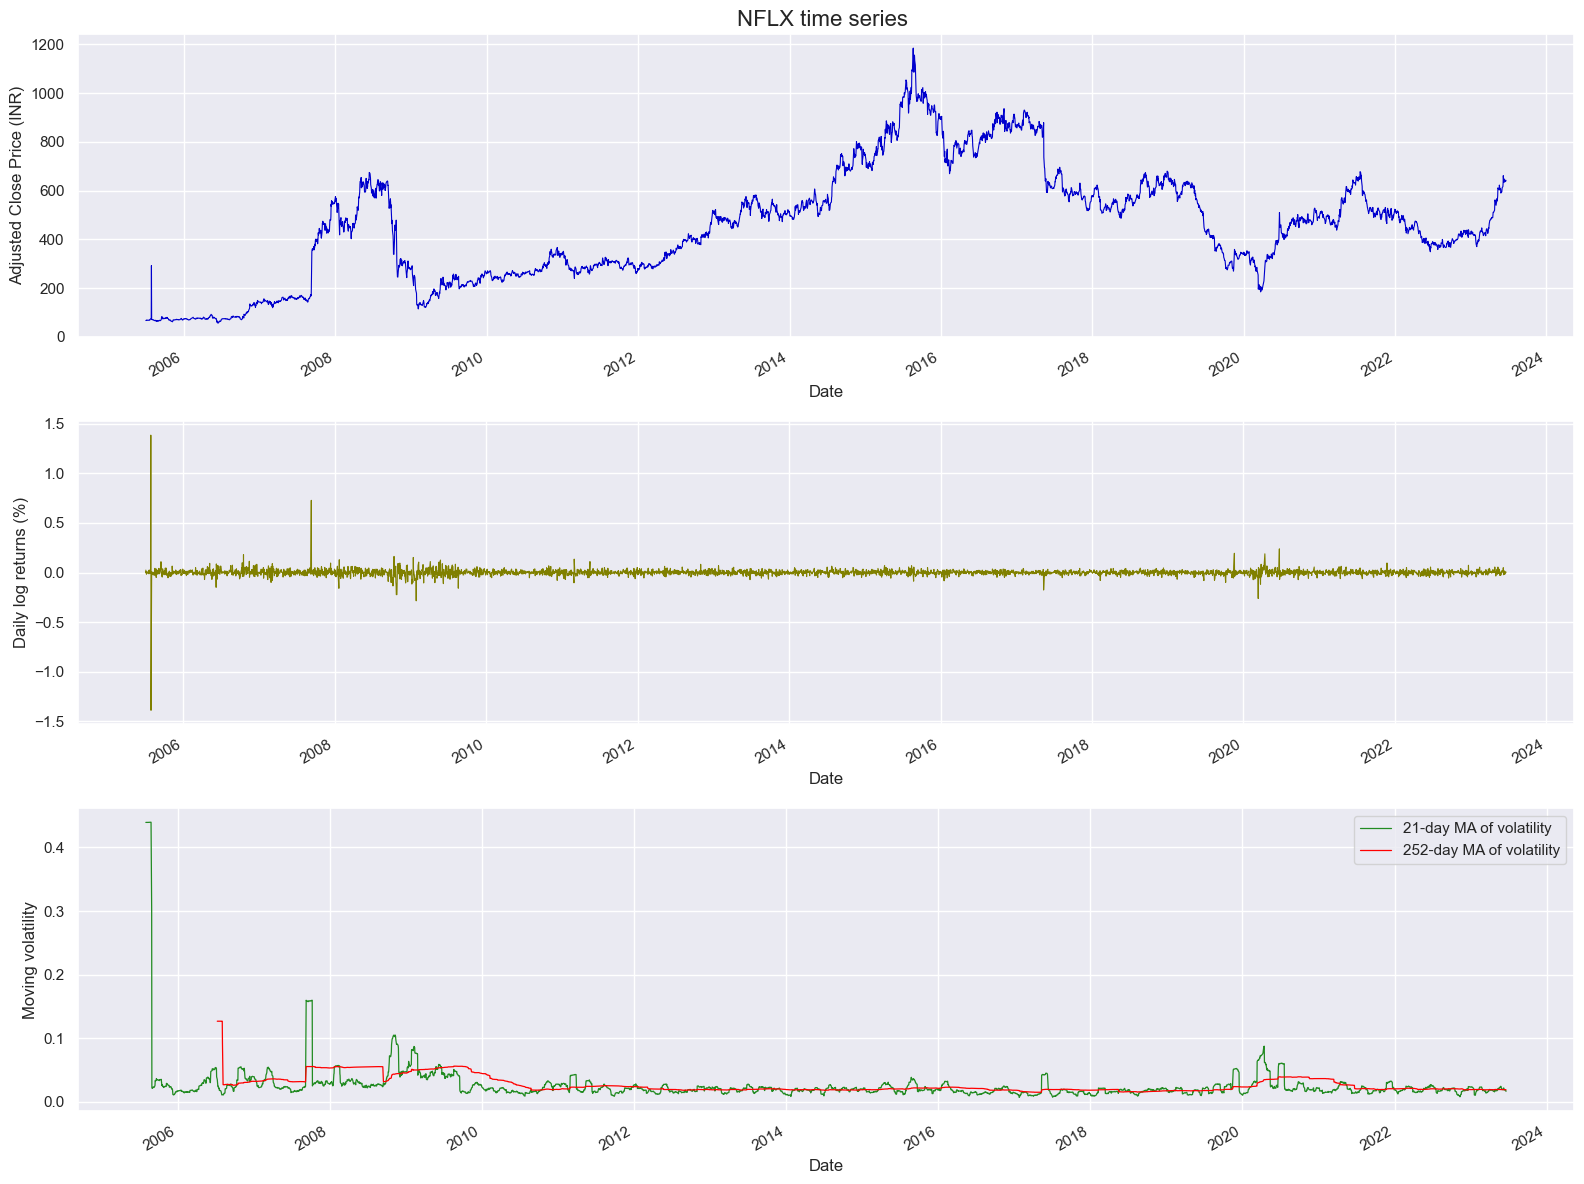

In [102]:
## Method I

M, N = 16, 12
fig, ax = plt.subplots(3, 1, figsize=(M, N))

df1['adj_close'].plot(ax=ax[0], linewidth=0.8, color='mediumblue')
ax[0].set_title(f"{ticker1} time series ", fontsize=16)
ax[0].set(ylabel="Adjusted Close Price (INR)")


df1['log_returns'].plot(ax=ax[1], linewidth=0.8, color='olive')
ax[1].set(ylabel="Daily log returns (%)")

df1['ma_std_21'].plot(ax=ax[2], color='forestgreen', linewidth = 0.9, label="21-day MA of volatility")
df1['ma_std_252'].plot(ax=ax[2], color='red', linewidth = 0.9, label="252-day MA of volatility")
ax[2].set(xlabel="Date", ylabel="Moving volatility")
ax[2].legend()

plt.tight_layout()

Points to note:
- Leverage effect is visible. There seems to be a pattern of prices going up and volatility being low in those phases and vice-versa.

In [103]:
## Method II

start3 = start2
end3 = end2
ticker3 = "^VIX"

df = yf.download([ticker2, ticker3], start=start3, end=end3, progress=True)

[*********************100%%**********************]  2 of 2 completed


In [104]:
df.shape

(10959, 12)

In [105]:
df.tail()

Adj Close               Close                High         \
                  ^GSPC   ^VIX        ^GSPC   ^VIX        ^GSPC   ^VIX   
Date                                                                     
2023-06-13  4369.009766  14.61  4369.009766  14.61  4375.370117  15.06   
2023-06-14  4372.589844  13.88  4372.589844  13.88  4391.819824  14.73   
2023-06-15  4425.839844  14.50  4425.839844  14.50  4439.200195  14.52   
2023-06-16  4409.589844  13.54  4409.589844  13.54  4448.470215  14.54   
2023-06-20  4388.709961  13.88  4388.709961  13.88  4400.149902  14.67   

                    Low                Open             Volume       
                  ^GSPC   ^VIX        ^GSPC   ^VIX       ^GSPC ^VIX  
Date                                                                 
2023-06-13  4349.310059  14.47  4352.609863  14.99  4275400000  0.0  
2023-06-14  4337.850098  13.83  4366.290039  14.48  4252110000  0.0  
2023-06-15  4362.600098  13.79  4365.330078  14.09  4176690000  0.0  
2023-06-16  4407.439941  13.48  4440.950195  14.49  6848600000  0.0  
2023-06-20  4367.189941  13.86  4396.109863  14.36  4055790000  0.0

In [106]:
df.head()

Adj Close            Close             High              Low  \
                 ^GSPC ^VIX       ^GSPC ^VIX       ^GSPC ^VIX       ^GSPC   
Date                                                                        
1980-01-02  105.760002  NaN  105.760002  NaN  108.430000  NaN  105.290001   
1980-01-03  105.220001  NaN  105.220001  NaN  106.080002  NaN  103.260002   
1980-01-04  106.519997  NaN  106.519997  NaN  107.080002  NaN  105.089996   
1980-01-07  106.809998  NaN  106.809998  NaN  107.800003  NaN  105.800003   
1980-01-08  108.949997  NaN  108.949997  NaN  109.290001  NaN  106.290001   

                 Open         Volume       
           ^VIX ^GSPC ^VIX     ^GSPC ^VIX  
Date                                       
1980-01-02  NaN   0.0  NaN  40610000  NaN  
1980-01-03  NaN   0.0  NaN  50480000  NaN  
1980-01-04  NaN   0.0  NaN  39130000  NaN  
1980-01-07  NaN   0.0  NaN  44500000  NaN  
1980-01-08  NaN   0.0  NaN  53390000  NaN

In [107]:
df3 = df.copy()

In [108]:
df3 = df3[['Adj Close']]

In [109]:
df3.columns

MultiIndex([('Adj Close', '^GSPC'),
            ('Adj Close',  '^VIX')],
           )

In [110]:
df3.columns = df3.columns.droplevel(0)

In [111]:
df3.columns

Index(['^GSPC', '^VIX'], dtype='object')

In [112]:
df3.rename(columns={"^GSPC": "sp500", "^VIX": "vix"}, inplace=True)

In [113]:
df3.tail()

,sp500,vix
Date,,
2023-06-13,4369.009766,14.61
2023-06-14,4372.589844,13.88
2023-06-15,4425.839844,14.50
2023-06-16,4409.589844,13.54
2023-06-20,4388.709961,13.88


In [114]:
df3.head()

,sp500,vix
Date,,
1980-01-02,105.760002,NaN
1980-01-03,105.220001,NaN
1980-01-04,106.519997,NaN
1980-01-07,106.809998,NaN
1980-01-08,108.949997,NaN


In [115]:
df3["log_returns"] = np.log(df3['sp500'] / df3['sp500'].shift(1))
df3["vol_returns"] = np.log(df3['vix'] / df3['vix'].shift(1))

In [116]:
df3.dropna(how="any", axis="rows", inplace=True)

In [117]:
df3.head()

,sp500,vix,log_returns,vol_returns
Date,,,,
1990-01-03,358.760010,18.190001,-0.002589,0.053640
1990-01-04,355.670013,19.219999,-0.008650,0.055079
1990-01-05,352.200012,20.110001,-0.009804,0.045266
1990-01-08,353.790009,20.260000,0.004504,0.007431
1990-01-09,349.619995,22.200001,-0.011857,0.091444


In [118]:
df3.tail()

,sp500,vix,log_returns,vol_returns
Date,,,,
2023-06-13,4369.009766,14.61,0.006909,-0.027010
2023-06-14,4372.589844,13.88,0.000819,-0.051257
2023-06-15,4425.839844,14.50,0.012105,0.043700
2023-06-16,4409.589844,13.54,-0.003678,-0.068500
2023-06-20,4388.709961,13.88,-0.004746,0.024801


In [119]:
df3.shape

(8430, 4)

In [120]:
corr_coeff = df3['log_returns'].corr(df3['vol_returns'])

In [121]:
corr_coeff

-0.7090609129739084

[Text(0.5, 1.0, 'S&P 500 vs. VIX (ρ = -0.709)'),
 Text(0.5, 0, 'S&P 500 log returns'),
 Text(0, 0.5, 'VIX log returns')]

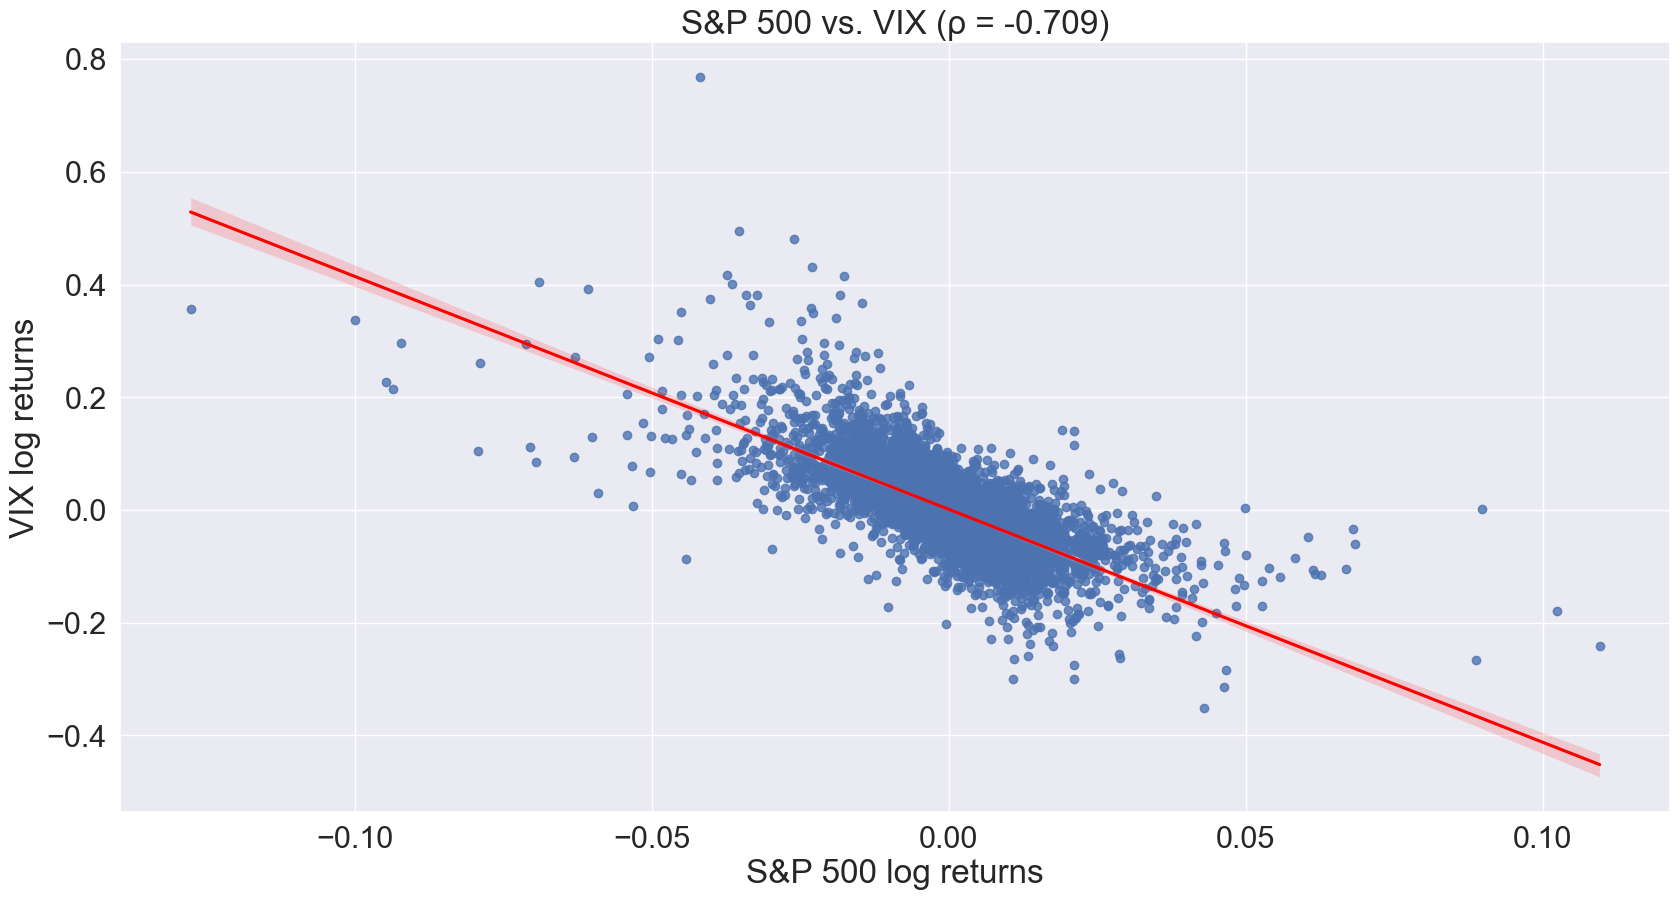

In [122]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2)
ax = sns.regplot(x='log_returns', y='vol_returns', data=df3, 
                 line_kws={'color':'red'})
ax.set(title=f"S&P 500 vs. VIX (ρ = {corr_coeff:.3f})", 
       xlabel="S&P 500 log returns", ylabel="VIX log returns")

Points to note:
- High negative value of correlation coefficient.
- Slope of the regression line which is also negative.

<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>

1. Barndorff‐Nielsen, O. E., & Shephard, N. (2002). Econometric analysis of realized volatility and its use in estimating stochastic volatility models. *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, 64(2), 253-280.
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R.(2001). Empirical properties of asset returns: stylized facts and statistical issues.
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons, 2005.
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press, 1997.
8. Quantra course on Time Series Analysis